In [39]:
import pickle

In [67]:
df = pickle.load( open( "main_pandas_dataframe.pickle", "rb" ) )
df

,transcript,type
0,thank much north carolina thank much thrilled ...,1
1,eric lara named daughter know carolina carolin...,1
2,think way look look back look press look dont ...,1
3,fantastically theres never time republican par...,1
4,super thursday jobs booming country incomes so...,1
...,...,...
2242,helped rescue joshua hell earth almost years l...,0
2243,hour know would grow old knew america prevail ...,0
2244,slavery build railroads highways defeat fascis...,0
2245,congress look opportunities us thrilling achie...,0


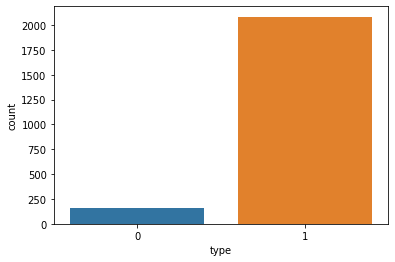

In [41]:
import seaborn as sns

sns.countplot(x='type', data=df)

In [42]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

def preprocess_text(sen):
    
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

[nltk_data] Downloading package stopwords to /home/daniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:
import numpy as np
X = []
y = np.array(df['type'])
sentences = np.array(df['transcript'])
for sen in sentences:
    X.append(preprocess_text(sen))

X = np.array(X)


In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
np.savez_compressed('dataset_split_transcripts.npz',
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test)

(1797,) (1797,) (450,) (450,)
